# VAE on CelebA Dataset


## Problem Description
We will try to generate celebrity faces from the CelebA large scale Large-scale CelebFaces Attributes Dataset. It has 202 thousand images of celebrity faces. We will target the generation of lower resolution and grayscale 45x45 pixels images using a VAE.

# Prepare the Data

The dataset can be downloaded from the following website - 
https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
We will only use the images and not the annotations for our task, because we are targeting unconditional generation of images.

## Prepare downsampled, cropped, grayscale data

As mentioned before, we will target the generation of 45x45 center cropped images. The dataset can be downloaded from 

https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ

Additionally, we will further simplify the task. It is very difficult to good quality colored images with a simple VAE. So we will target generatio of grayscale image.

We will prepare the data with the help of tensorflow jpeg decode function and save it as numpy data for further use.

In [ ]:
import zipfile
from tqdm import tqdm
import numpy as np
import gzip
import tensorflow as tf


# The dataset 'img_align_celeba.zip' is downloaded from
# https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ
with zipfile.ZipFile('img_align_celeba.zip', 'r') as file:
    image_files = [f.filename for f in file.filelist if (not f.is_dir()) and f.filename.endswith('.jpg')]
    X_train = np.empty([len(image_files),45,45,1],dtype='uint8')
    for i, filename in enumerate(tqdm(image_files)):
        X_train[i] = tf.io.decode_and_crop_jpeg(file.read(filename),
                                                crop_window=[5,0,45,45],
                                                ratio=4,
                                                channels=1).numpy()
X_train = X_train.squeeze()
with gzip.GzipFile('celeba_gray_45x45.npy.gz','wb',5) as save_file:
    np.save(save_file, X_train)

100%|████████████████████████████████████████████████████████████████████████| 202599/202599 [00:43<00:00, 4633.38it/s]


## Load and visualize data

Now that we have saved the data it can be loaded by numpy.

In [ ]:
import numpy as np
import gzip

with gzip.GzipFile('celeba_gray_45x45.npy.gz','rb') as save_file:
    X_train = np.load(save_file)
X_train = X_train.astype('float32')/255.

Here's a collage of training images.

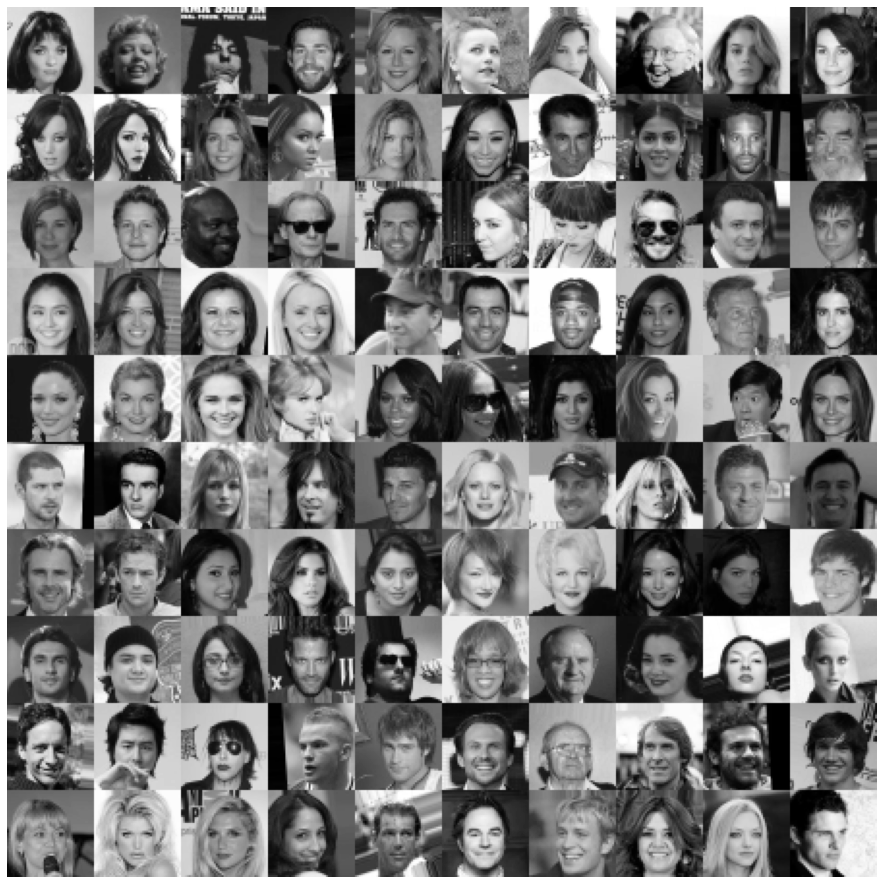

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
plt.imshow(X_train[600:700].transpose(1,2,0).reshape(45,45,10,10).transpose(2,0,3,1).reshape(450,450),cmap='gray')
plt.axis('off')
plt.show()

## K-Means

Generation of high quality (i.e. sharp, not blurred) images in the pixel space using a simple VAE is a difficult task. To make it easier, we will compress the data a bit, and conver it to tokens, i.e. categorical data. We will consider 3x3 windows with a stride of 2 (overlap of 1 pixel) and convert them to vector quantized tokens - 2048 tokens in toal per window.

Predicting range of probabilites over categorical data, instead of continuous data will increase the expressivity of the VAE decoder and help it generate sharp images.

In [ ]:
import numba as nb

@nb.njit
def overlapped_segments(X):
    segments = np.zeros((X.shape[0],22,22,3,3),dtype=np.float32)

    for k, x in enumerate(X):
        for i1,i2 in zip(range(22),range(0,43,2)):
            for j1,j2 in zip(range(22),range(0,43,2)):
                segments[k,i1,j1] = x[i2:i2+3,j2:j2+3]
    return segments

@nb.njit
def overlap_and_add(segments):
    X = np.zeros((segments.shape[0],45,45),dtype=np.float32)

    for k, seg in enumerate(segments):
        for i1,i2 in zip(range(22),range(0,43,2)):
            for j1,j2 in zip(range(22),range(0,43,2)):
                X[k,i2:i2+3,j2:j2+3] += seg[i1,j1]
    return X

We will form the windows which will be input to the K-means algorithm.

In [ ]:
X_train_segments = overlapped_segments(X_train)
X_train_segments = X_train_segments.reshape(-1,3*3)
X_train_segments.shape

(98057916, 9)

Since we have a large number of windows and clusters, we will run minibatch k-means. After that we assign the found centroids to vector quantize all the windows.

In [ ]:
from sklearn.cluster import MiniBatchKMeans
num_clusters = 2048

k_means = MiniBatchKMeans(n_clusters=num_clusters,
                          n_init=12,
                          batch_size=6*512,
                          max_iter=1,
                          max_no_improvement=15,
                          verbose=2,
                          compute_labels=False)

seg_inds = np.arange(len(X_train_segments),dtype=int)
np.random.shuffle(seg_inds)
segment_samples = X_train_segments[seg_inds]

k_means.fit(segment_samples)

Now we vector quantize the windows, we have 22x22 windows per image.

In [ ]:
X_train_vq = k_means.predict(X_train_segments).reshape(-1,22,22)

Computing label assignment and total inertia


### Reconstruction test
Now we will show that we can approximately reconstruct the images their vector quantized window tokens by overlappind and adding the corresponding centroids. This would indicate that we have effectively compressed the data, albeit possibly with some distortion (lossy compression).

In [ ]:
recons_mask = overlap_and_add(np.ones_like(X_train[0:1]))
centroids = k_means.cluster_centers_.reshape(-1,3,3)

def reconstruct_images(X):
    return overlap_and_add(centroids[X])/recons_mask

In [ ]:
mask = overlap_and_add(np.ones_like(X_train[0:1]))
rconstructed = overlap_and_add(k_means.cluster_centers_[X_train_vq[99:100].reshape(-1)].reshape(-1,22,22,3,3))/mask

**Original image**

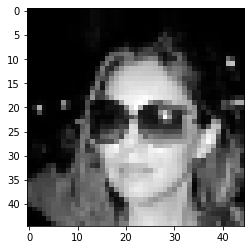

In [ ]:
plt.imshow(X_train[2133],cmap='gray')

**Reconstructed from vector quantized windows**

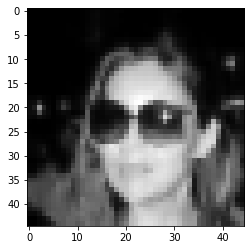

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(reconstruct_images(X_train_vq[2133:2134]).squeeze(),cmap='gray')

We see that there is very little distortion.

Now we will save the vector quantized data, and the centroids for further use in training the VAE.

In [ ]:
import zipfile
import pickle

with zipfile.ZipFile('images_vq_22x22x1024.zip',mode='w',
                     compression=zipfile.ZIP_DEFLATED,
                     compresslevel=5) as zfile:
    with zfile.open('images.npy','w') as file:
        np.save(file, X_train_vq.astype('int32'))
    with zfile.open('centroids.npy','w') as file:
        np.save(file, centroids.astype('float32'))
    with zfile.open('k_means.pkl','w') as file:
        data=pickle.dumps(k_means)
        file.write(data)

# VAE
Now we will define our VAE model, train it and generate images.

## Load quantized data

As mentioned before, we will use the vector quantized data for the VAE. After the VAE generates vector quantized data, the actual image in the pixel space can be reconstructed by overlapping and adding the corresponding window centroids.

Let's first load and view some reconstructed vector quantized images.

In [1]:
import zipfile
import pickle
import numpy as np

with zipfile.ZipFile('images_vq_22x22x1024.zip',mode='r') as zfile:
    with zfile.open('images.npy','r') as file:
        X_train_vq = np.load(file)
    with zfile.open('centroids.npy','r') as file:
        centroids = np.load(file)

This is the function used for overlapping and adding windows

In [2]:
import numba as nb

@nb.njit
def overlap_and_add(segments):
    X = np.zeros((segments.shape[0],45,45),dtype=np.float32)

    for k, seg in enumerate(segments):
        for i1,i2 in zip(range(22),range(0,43,2)):
            for j1,j2 in zip(range(22),range(0,43,2)):
                X[k,i2:i2+3,j2:j2+3] += seg[i1,j1]
    return X

recons_mask = overlap_and_add(np.ones([1,22,22,3,3],dtype='float32'))

def reconstruct_images(X):
    return overlap_and_add(centroids[X])/recons_mask

These are some reconstructed (i.e., de-compressed) images.

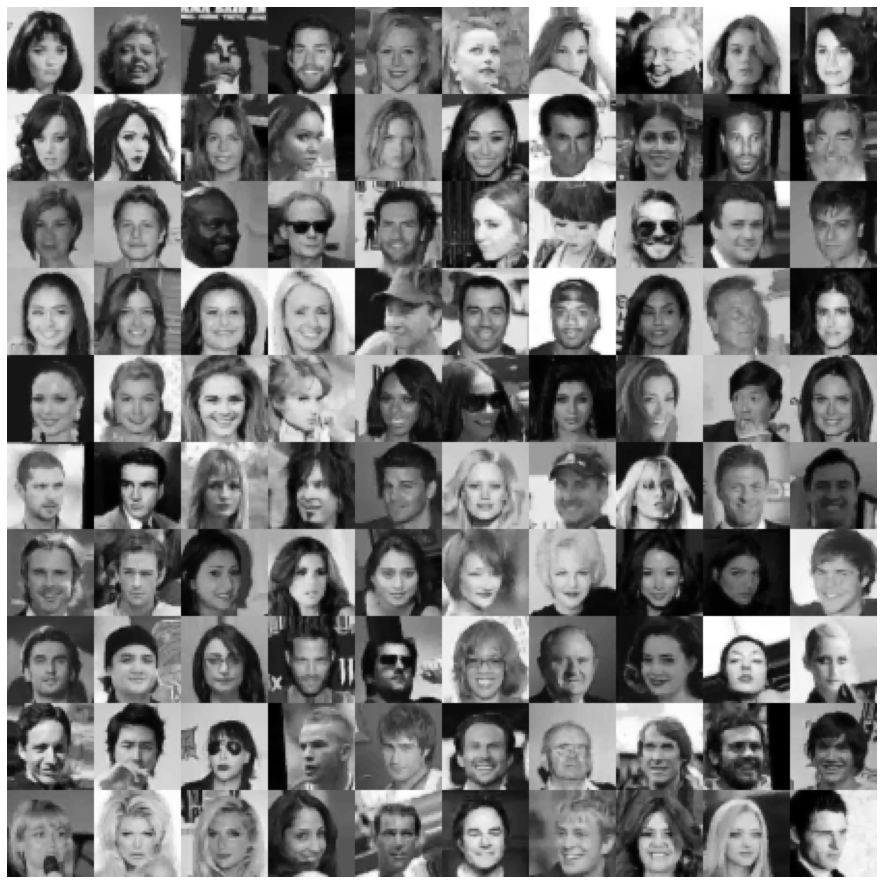

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
plt.imshow(reconstruct_images(X_train_vq[600:700])
              .transpose(1,2,0).reshape(45,45,10,10)
              .transpose(2,0,3,1).reshape(450,450),cmap='gray')
plt.axis('off')
plt.show()

## Train validation split

One of the advantages of VAE over GAN is that, we can easily verify if the model is overfitting (i.e, memorizing) the training data by monitoring the value of lower bound in training and validation sets.

So, we will create a validation split to monitor possible overfitting.

In [ ]:
from sklearn.model_selection import train_test_split
X_train_vq, X_val_vq = train_test_split(X_train_vq, test_size=0.1,
                                                  random_state=777)

## Model Definition

We will form a convolutional VAE with 3 residual convolutional blocks for both the encoder and the decoder. We will extensively use batch normalization to stabilize the training.

Additionally we will slightly modify the VAE objective as follow -
* We will use a large latent space of dimension 512. In order to ensure that the VAE utizes all these dimensions we will threshold the KL-divergence (compression) loss for each dimension to a minimum value. This is known as so called "free bits" to each component of the latent space.
* We will utilize a modified objective where the kl-divergence loss is multiplied by a factor $\beta$ before being added to the total loss. This type of VAE is known as a $\beta$-VAE.
* To easily train the model we will slowly increase the value of $\beta$ from a low value to it's final value. This is known as $\beta$ annealing.
* However we will not use a fina value of $\beta=1$ (vanilla VAE), but $\beta=0.025$. This will help us generate good quality images. Also, we noticed that the posterior collapses for high value of $\beta$.

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers, metrics, initializers


class SamplingKLLoss(layers.Layer):     
    def __init__(self, threshold_value = 0.1, beta_value=0.05,
                 *args, **kwargs):
        super().__init__(*args,**kwargs)
        
        self.threshold_value = threshold_value
        self.beta_value = beta_value
    
    def build(self, input_shape):
        self.threshold = self.add_weight(name='threshold', shape= (),
                                         initializer=initializers.Constant(self.threshold_value),
                                        trainable=False)
        
        self.beta = self.add_weight(name='beta', shape= (),
                                    initializer=initializers.Constant(self.beta_value),
                                    trainable=False)
        self.built = True
        
    def call(self, inputs):
        mean_q, std_q = inputs
        eps = tf.random.normal(tf.shape(mean_q))
        z = eps*std_q + mean_q

        elem_compress_loss = 0.5*(std_q**2 + mean_q**2 - 1.) - tf.math.log(std_q+1e-7)
        
        compress_loss = tf.reduce_sum(tf.maximum(elem_compress_loss, self.threshold),
                                      axis=-1)
        
        self.add_metric(compress_loss, name='kl_loss', aggregation='mean')

        self.add_loss(tf.reduce_mean(compress_loss) * self.beta)
        
        return z

latent_dim = 512

def get_encoder():
    inp = layers.Input(shape=[22,22],name='input')
    x = inp

    x = layers.Embedding(2048, 256, name='input_embedding')(x)

    # First Conv block
    y = x
    x = layers.BatchNormalization(name='block1_bn1')(x)
    x = layers.Activation('elu', name='block1_activ1')(x)
    x = layers.Conv2D(256, (3,3), padding='same', use_bias=False,
                      name='block1_conv1')(x)
    x = layers.BatchNormalization(name='block1_bn2')(x)
    x = layers.Activation('elu', name='block1_activ2')(x)
    x = layers.Conv2D(256, (3,3), padding='same', use_bias=False,
                      strides=(2,2),
                      name='block1_conv2')(x)
    y = layers.AveragePooling2D([2,2], name='pool1')(y)
    x = layers.Add(name='res_conn_1')([x,y])

    x = layers.ZeroPadding2D([(0,1),(0,1)], name='zero_padding1')(x)

    # Second Conv block
    y = x
    x = layers.BatchNormalization(name='block2_bn1')(x)
    x = layers.Activation('elu', name='block2_activ1')(x)
    x = layers.Conv2D(256, (3,3), padding='same', use_bias=False,
                      name='block2_conv1')(x)
    x = layers.BatchNormalization(name='block2_bn2')(x)
    x = layers.Activation('elu', name='block2_activ2')(x)
    x = layers.Conv2D(256, (3,3), padding='same', use_bias=False,
                      strides=(2,2),
                      name='block2_conv2')(x)
    y = layers.AveragePooling2D([2,2], name='pool2')(y)
    x = layers.Add(name='res_conn_2')([x,y])


    # Third Conv block
    y = x
    x = layers.BatchNormalization(name='block3_bn1')(x)
    x = layers.Activation('elu', name='block3_activ1')(x)
    x = layers.Conv2D(256, (3,3), padding='same', use_bias=False,
                      name='block3_conv1')(x)
    x = layers.BatchNormalization(name='block3_bn2')(x)
    x = layers.Activation('elu', name='block3_activ2')(x)
    x = layers.Conv2D(256, (3,3), padding='same', use_bias=False,
                      strides=(2,2),
                      name='block3_conv2')(x)
    y = layers.AveragePooling2D([2,2], name='pool3')(y)
    x = layers.Add(name='res_conn_3')([x,y])


    # Final layers
    x = layers.BatchNormalization(name='final_bn')(x)
    x = layers.Activation('elu', name='final_activ')(x)

    x = layers.Flatten(name='flatten')(x)
    # x = layers.Dense(512, activation='elu', name='final_dense')(x)
    z_mean = layers.Dense(latent_dim, name='dense_mean')(x)
    z_std = layers.Dense(latent_dim, activation=tf.nn.softplus,
                         name='dense_std')(x)

    model = models.Model(inp, [z_mean,z_std], name='encoder_model')
    return model


def get_decoder():
    inp = layers.Input([latent_dim],name='input')
    x = inp

    # x = layers.Dense(512, activation='elu', name='dense1')(x)
    x = layers.Dense(3*3*256, name='dense2')(x)
    x = layers.Reshape([3,3,256], name='reshape')(x)

    # First Conv Block
    
    y = x
    y = layers.UpSampling2D([2,2], name='upsample1')(y)

    x = layers.BatchNormalization(name='block1_bn1')(x)
    x = layers.Activation('elu', name='block1_activ1')(x)
    x = layers.Conv2DTranspose(256, (3,3), padding='same', use_bias=False,
                      strides=(2,2),
                      name='block1_conv1')(x)
    x = layers.BatchNormalization(name='block1_bn2')(x)
    x = layers.Activation('elu', name='block1_activ2')(x)
    x = layers.Conv2DTranspose(256, (3,3), padding='same', use_bias=False,
                      name='block1_conv2')(x)
    x = layers.Add(name='res_conn_1')([x,y])

    # Second Conv Block
    
    y = x
    y = layers.UpSampling2D([2,2], name='upsample2')(y)

    x = layers.BatchNormalization(name='block2_bn1')(x)
    x = layers.Activation('elu', name='block2_activ1')(x)
    x = layers.Conv2DTranspose(256, (3,3), padding='same', use_bias=False,
                      strides=(2,2),
                      name='block2_conv1')(x)
    x = layers.BatchNormalization(name='block2_bn2')(x)
    x = layers.Activation('elu', name='block2_activ2')(x)
    x = layers.Conv2DTranspose(256, (3,3), padding='same', use_bias=False,
                      name='block2_conv2')(x)
    x = layers.Add(name='res_conn_2')([x,y])

    # Third Conv Block
    x = layers.Cropping2D([(0,1),(0,1)], name='cropping3')(x)
    
    y = x
    y = layers.UpSampling2D([2,2], name='upsample3')(y)

    x = layers.BatchNormalization(name='block3_bn1')(x)
    x = layers.Activation('elu', name='block3_activ1')(x)
    x = layers.Conv2DTranspose(256, (3,3), padding='same', use_bias=False,
                      strides=(2,2),
                      name='block3_conv1')(x)
    x = layers.BatchNormalization(name='block3_bn2')(x)
    x = layers.Activation('elu', name='block3_activ2')(x)
    x = layers.Conv2D(256, (3,3), padding='same', use_bias=False,
                      name='block3_conv2')(x)
    x = layers.Add(name='res_conn_3')([x,y])

    x = layers.BatchNormalization(name='final_bn')(x)
    x = layers.Activation('elu', name='final_activ')(x)
    x = layers.Dense(2048, name='final_dense')(x)
    
    outp = x
    model = models.Model(inp, outp, name='decoder_model')
    return model

Since we are using categorical targets for the decoder we will use crossentropy loss as reconstruction loss.

In [5]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    encoder_model = get_encoder()
    decoder_model = get_decoder()

    sampling_layer = SamplingKLLoss(threshold_value = 0.01, 
                                    beta_value=0.0005, 
                                    name='sampling_layer')

    vae_inp = layers.Input([22,22], name='vae_input')
    z_mean, z_std = encoder_model(vae_inp)
    z = sampling_layer([z_mean,z_std])
    vae_outp = decoder_model(z)

    vae_model = models.Model(vae_inp, vae_outp, name='vae_model')
    xent_loss = losses.SparseCategoricalCrossentropy(from_logits=True, name='xent_loss')
    optim = optimizers.Adam(learning_rate=1e-3)
    acc = metrics.SparseCategoricalAccuracy(name='acc')

    vae_model.compile(optim, xent_loss, [acc])

vae_model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

## Training

We will slowly increase the $\beta$ value from 0.005 to 0.021. Then in the second stage we will further increase $\beta$ ot 0.025. We saved loaded the weights many times during training. We trained for a total of around 160 epochs. We reduced the learning rate along the way.

We trained the model for 160 epochs. We saved and loaded the weights during these training process.

Saving the the image outputs of the intermediate steps dramatically increases the size of the jupyter notebook, so we cleared the outputs of the following cells. But they are available in the previous GitHub commit of this file.

In [ ]:
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint, ReduceLROnPlateau

def increase_beta(epoch, logs):
    current_beta = sampling_layer.beta.numpy()
    if current_beta < 0.021:
        sampling_layer.beta.assign(min(0.021,current_beta+0.0005))
    print('\nNew beta value:',sampling_layer.beta.numpy())

def plot_samples(epoch, logs):
    noise = np.random.randn(100,latent_dim)
    generated = reconstruct_images(decoder_model.predict(noise).argmax(-1))
    plt.figure(figsize=[16,16])
    plt.imshow(generated.reshape(10,10,45,45).transpose(0,2,1,3).reshape(450,450),cmap='gray')
    plt.axis('off')
    plt.show()
    plt.pause(0.01)

callbacks = []
callbacks.append(LambdaCallback(on_epoch_end=increase_beta))
callbacks.append(ModelCheckpoint(filepath='saved_model.h5',save_best_only=True, 
                                 save_weights_only=True))
callbacks.append(LambdaCallback(on_epoch_end=plot_samples))
# callbacks.append(ReduceLROnPlateau(patience=4,verbose=1,factor=0.5))

In [ ]:
vae_model.fit(X_train_vq, X_train_vq, batch_size=512, epochs=100, 
              validation_data=(X_val_vq,X_val_vq),
              callbacks=callbacks)

In [ ]:
vae_model.optimizer.learning_rate.assign(5e-4)
vae_model.fit(X_train_vq, X_train_vq, batch_size=512, epochs=100, 
              validation_data=(X_val_vq,X_val_vq),
              callbacks=callbacks, initial_epoch=70)

In [ ]:
vae_model.optimizer.learning_rate.assign(2.5e-4)
vae_model.fit(X_train_vq, X_train_vq, batch_size=512, epochs=120, 
              validation_data=(X_val_vq,X_val_vq),
              callbacks=callbacks, initial_epoch=100)

In [ ]:
vae_model.optimizer.learning_rate.assign(1e-4)
vae_model.fit(X_train_vq, X_train_vq, batch_size=512, epochs=140, 
              validation_data=(X_val_vq,X_val_vq),
              callbacks=callbacks, initial_epoch=120)

In [ ]:
vae_model.optimizer.learning_rate.assign(5e-5)
vae_model.fit(X_train_vq, X_train_vq, batch_size=512, epochs=160, 
              validation_data=(X_val_vq,X_val_vq),
              callbacks=callbacks, initial_epoch=140)

Now we increase the value of $\beta$ to its final value 0.025.

In [ ]:
vae_model.optimizer.learning_rate.assign(1e-5)
vae_model.fit(X_train_vq, X_train_vq, batch_size=512, epochs=160, 
              validation_data=(X_val_vq,X_val_vq),
              callbacks=callbacks, initial_epoch=140)

## Evaluation and Experiments

### Load Weights
Let's load the final saved weights of the model.

In [6]:
vae_model.load_weights('saved_model.h5')

### Generation Test

We can generate better quality images and avoid distorted images by reducint the standard deviaion (i.e., "temperature") of the input gaussian noise to the decoder. Although this will lead to less diversity in the generated images, they will have higher quality and less distortion.

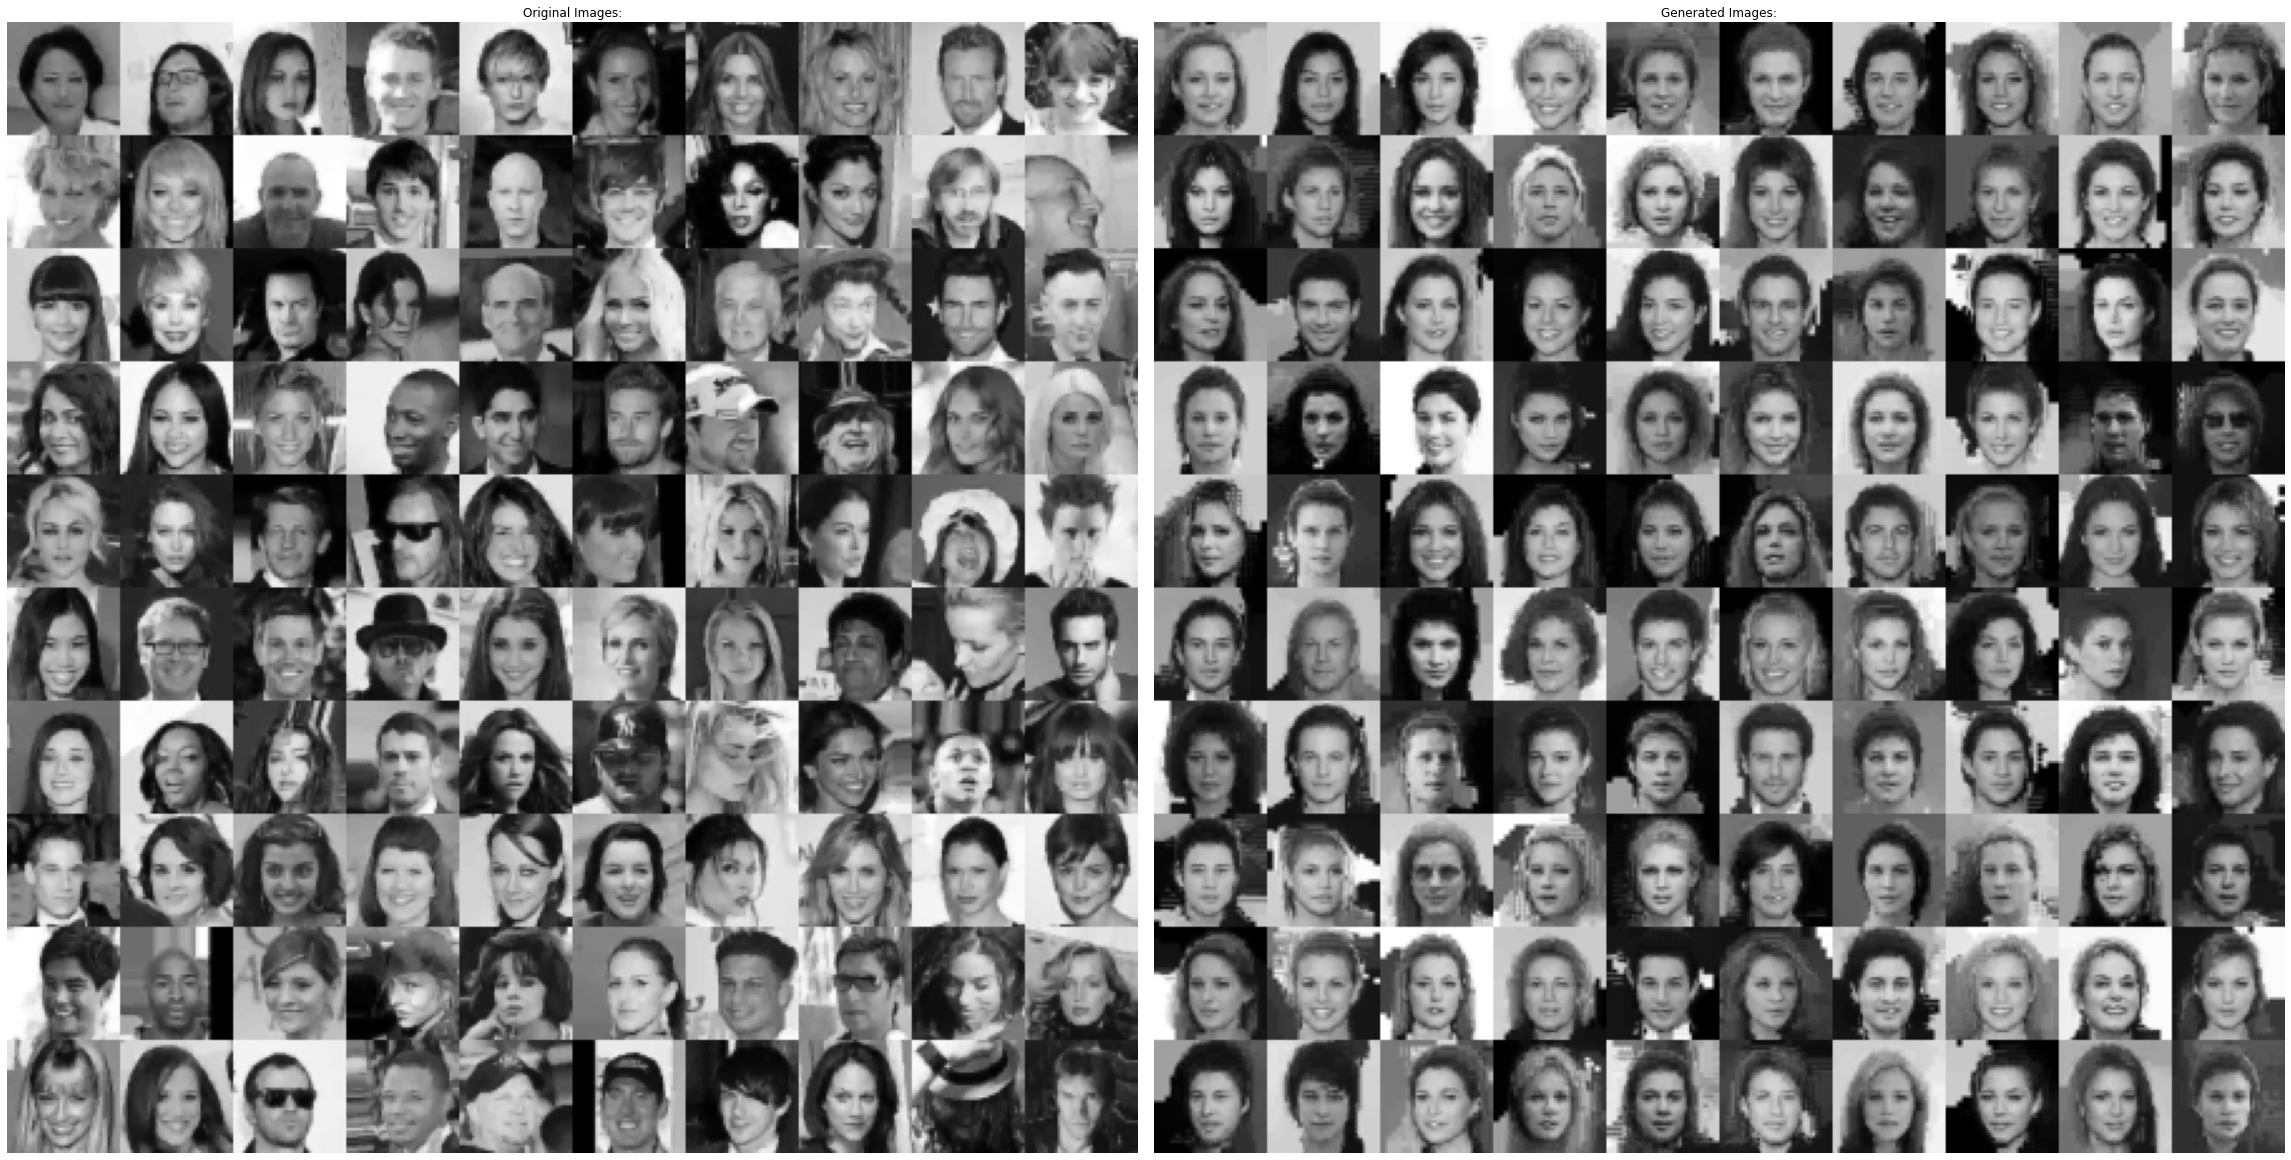

In [14]:
import numpy as np

plt.figure(figsize=[32,16])
plt.subplot(1,2,1)
original = reconstruct_images(X_train_vq[100:200])
plt.imshow(original.reshape(10,10,45,45).transpose(0,2,1,3).reshape(450,450),cmap='gray')
plt.axis('off')
plt.title('Original Images:')

plt.subplot(1,2,2)
temperature = 0.6
noise = np.random.randn(100,latent_dim) * temperature
generated = reconstruct_images(decoder_model.predict(noise).argmax(-1))
plt.imshow(generated.reshape(10,10,45,45).transpose(0,2,1,3).reshape(450,450),cmap='gray')
plt.axis('off')
plt.title('Generated Images:')
plt.tight_layout()
plt.show()

We see that we are getting sharp images albeit with less variety, and the background is often not generated by the model.

### Random walk in the image manifold
We can take a random walk in the latent space see how one face gradually evolves into another.

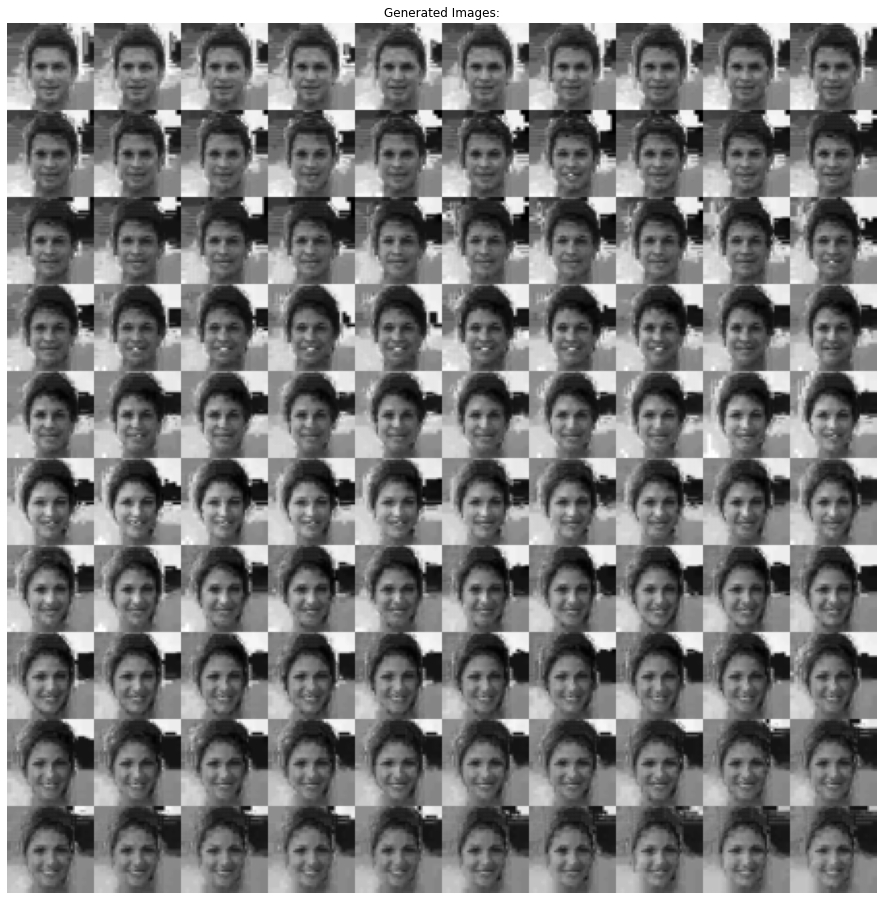

In [28]:
noise_init = np.random.randn(latent_dim)*0.5 
displacements = np.random.randn(100,latent_dim)
displacements = displacements*1/np.linalg.norm(displacements,axis=-1,keepdims=True)
cumulative_displacements = np.cumsum(displacements,axis=0)
noise = noise_init + cumulative_displacements


generated = reconstruct_images(decoder_model.predict(noise).argmax(-1))
plt.figure(figsize=[16,16])
plt.imshow(generated.reshape(10,10,45,45).transpose(0,2,1,3).reshape(450,450),cmap='gray')
plt.axis('off')
plt.title('Generated Images:')
plt.show()

View the images from left to right and top to bottom.

## Reconstruction Test

Now we will try to feed some of the original images to the auto-encoder and try to reconstruct them. We will only use the mean of of the posterior distribution.

1/1 [==============================] - 0s 20ms/step


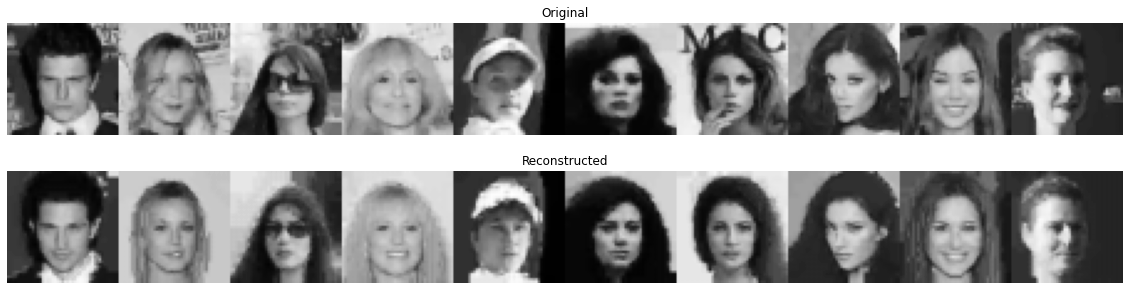

In [33]:
X_train_mu, X_train_sigma = encoder_model.predict(X_train_vq[90:100])
X_train_rec = decoder_model.predict(X_train_mu,verbose=1).argmax(-1)

orig_samples = reconstruct_images(X_train_vq[90:100])
recons_samples = reconstruct_images(X_train_rec)

plt.figure(figsize=[20,5])
plt.subplot(211)
plt.imshow(orig_samples.transpose(1,0,2).reshape(45,450),cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(212)
plt.imshow(recons_samples.transpose(1,0,2).reshape(45,450),cmap='gray')
plt.axis('off')
plt.title('Reconstructed')
plt.show()

We see that we don't exactly get back the original faces, but similar faces. This is due to the probabilistic nature of the autoencoder.